In [1]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.5 MB/s eta 0:00:00


In [18]:
import boto3
import botocore
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [3]:
# Defining functions for updating git files
def runcmd(command):
  res = subprocess.run(command, shell=True, capture_output=True, text=True)
  print(res.stdout, res.stderr)

def copytogit():
  source = "drive/MyDrive/Colab\ Notebooks/createmodel.ipynb"
  dest = "github-private-learning/"
  res = subprocess.run(
      "cp %s %s" % (source, dest),
      cwd="/content",
      shell=True,
      capture_output=True,
      text=True
  )
  print(res.stdout, res.stderr)

def commitandpush(comment):
  runcmd("git add -u")
  runcmd("git commit -m \"%s\"" % comment)
  runcmd("git push origin main")

In [4]:
# Connect to GitHub for Colab
email = input("Input GitHub Email: ")
username = input("Input GitHub Username: ")
github_token = input("Access Token: ")
clear_output()

runcmd("git config --global user.email \"%s\"" % email)
runcmd("git config --global user.name \"%s\"" % username)
!git clone https://github.com/NahcoCZ/github-private-learning.git
%cd github-private-learning/
runcmd("git remote add origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))
runcmd("git remote set-url origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))

 
 
Cloning into 'github-private-learning'...
remote: Enumerating objects: 11741, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 11741 (delta 19), reused 34 (delta 4), pack-reused 11691
Receiving objects: 100% (11741/11741), 390.93 MiB | 50.35 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (11737/11737), done.
/content/github-private-learning
 fatal: remote origin already exists.

 


In [5]:
# Connect to google drive to update files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Download the data files from AWS S3 Bucket if needed
session = boto3.Session(
    aws_access_key_id=input("Access Key: "),
    aws_secret_access_key=input("Secret Key: "),
    aws_session_token=input("Session Token: ")
)
s3 = session.client('s3')

# Clear output to prevent AWS credential leak
clear_output()

try:
    s3.download_file("lolipoppers-project", "npy/image_data.npy", "image_data.npy")
    s3.download_file("lolipoppers-project", "npy/label_data.npy", "label_data.npy")
    print('File downloaded successfully.')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '404':
        print('The file does not exist.')
    else:
        print('An error occurred while downloading the file:', e)

File downloaded successfully.


In [7]:
# Load downloaded data into numpy.ndarray
X = np.load("image_data.npy")
Y = np.load("label_data.npy")

# Declare label names and declaring functions for later use
label_names = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
    'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair',
    'Traffic Light'
]


def decodeDataset(coded):
    return label_names[np.argmax(coded, axis=1)]


def decode(label):
    return label_names[np.argmax(label)]


def plotImage(img, label):
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label)
    plt.imshow(img)
    plt.show()

In [8]:
# Split the training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

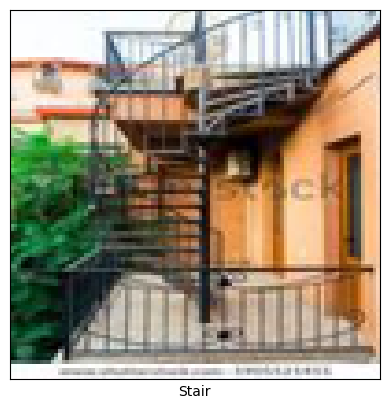

In [9]:
# Displaying one example from the dataset after splitting
plotImage(xtrain[0], decode(ytrain[0]))

In [10]:
# Defining compilation and training functions
def compile(model, epoch):
  # Compilation using adam optimization algorithm
  model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
  )
  history = model.fit(
    xtrain,
    ytrain,
    epochs=epoch,
    validation_data=(xtest, ytest)
  )
  return model, history

def setfigure():
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.show()

def evaluate(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def checkmodel(model, epoch):
  result, hist = compile(model, epoch)
  evaluate(hist)
  test_loss, test_acc = result.evaluate(xtest, ytest, verbose=2)
  return result, hist

def comparegraph(hist1, hist2):
  hist = [hist1, hist2]
  for i in hist:
    plt.plot(i.history['accuracy'], label='accuracy')
  setfigure()

  for i in hist:
    plt.plot(i.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def compareacc(model1, model2):
  model1.evaluate(xtest, ytest, verbose=2)
  model2.evaluate(xtest, ytest, verbose=2)

In [11]:
# Model Creation
firstModel = tf.keras.models.Sequential([
    # CNN Layers
    # 2D Convolution operation with 32 filters and 3x3 filter size
    # Smaller filter size will capture finer details on the image
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    # Max Pooling to reduce spatial dimension through 2x2 pooling window
    # Smaller pool size will capture more detail
    MaxPooling2D((2, 2)),
    # Adding more Convolution layers
    # filter count increased to capture more details and patterns
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((3, 3)),
    Conv2D(128, (3, 3), activation="relu"),
    # Convert to 1 dimensional array with Flatten
    Flatten(),
    # Use dense to capture the patterns and produce output
    Dense(64, activation="relu"),
    Dense(12)
])

Epoch 1/20
294/294 [==============================] - 16s 14ms/step - loss: 0.5769 - accuracy: 0.3101 - val_loss: 0.2578 - val_accuracy: 0.3257
Epoch 2/20
294/294 [==============================] - 3s 11ms/step - loss: 0.2446 - accuracy: 0.3557 - val_loss: 0.2378 - val_accuracy: 0.3696
Epoch 3/20
294/294 [==============================] - 4s 12ms/step - loss: 0.2299 - accuracy: 0.3877 - val_loss: 0.2281 - val_accuracy: 0.3926
Epoch 4/20
294/294 [==============================] - 3s 12ms/step - loss: 0.2142 - accuracy: 0.4327 - val_loss: 0.2195 - val_accuracy: 0.4194
Epoch 5/20
294/294 [==============================] - 3s 11ms/step - loss: 0.1972 - accuracy: 0.4971 - val_loss: 0.2149 - val_accuracy: 0.4403
Epoch 6/20
294/294 [==============================] - 3s 11ms/step - loss: 0.1803 - accuracy: 0.5559 - val_loss: 0.2065 - val_accuracy: 0.4889
Epoch 7/20
294/294 [==============================] - 4s 12ms/step - loss: 0.1624 - accuracy: 0.6175 - val_loss: 0.2131 - val_accuracy: 0.485

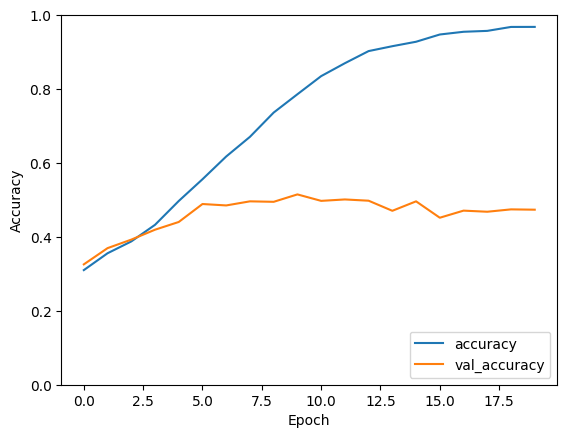

74/74 - 0s - loss: 0.6138 - accuracy: 0.4736 - 274ms/epoch - 4ms/step


(<keras.engine.sequential.Sequential at 0x7f01d215caf0>,
 <keras.callbacks.History at 0x7f01d21bcd30>)

In [12]:
checkmodel(firstModel, 20)

In [13]:
#Second model
second_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])

Epoch 1/10
294/294 [==============================] - 6s 14ms/step - loss: 0.4973 - accuracy: 0.3281 - val_loss: 0.2365 - val_accuracy: 0.3781
Epoch 2/10
294/294 [==============================] - 4s 12ms/step - loss: 0.2295 - accuracy: 0.4051 - val_loss: 0.2289 - val_accuracy: 0.3781
Epoch 3/10
294/294 [==============================] - 4s 13ms/step - loss: 0.2127 - accuracy: 0.4540 - val_loss: 0.2124 - val_accuracy: 0.4638
Epoch 4/10
294/294 [==============================] - 4s 12ms/step - loss: 0.1935 - accuracy: 0.5136 - val_loss: 0.2057 - val_accuracy: 0.4868
Epoch 5/10
294/294 [==============================] - 4s 13ms/step - loss: 0.1760 - accuracy: 0.5705 - val_loss: 0.2047 - val_accuracy: 0.4949
Epoch 6/10
294/294 [==============================] - 4s 12ms/step - loss: 0.1559 - accuracy: 0.6271 - val_loss: 0.2056 - val_accuracy: 0.4996
Epoch 7/10
294/294 [==============================] - 4s 12ms/step - loss: 0.1410 - accuracy: 0.6767 - val_loss: 0.2158 - val_accuracy: 0.5038

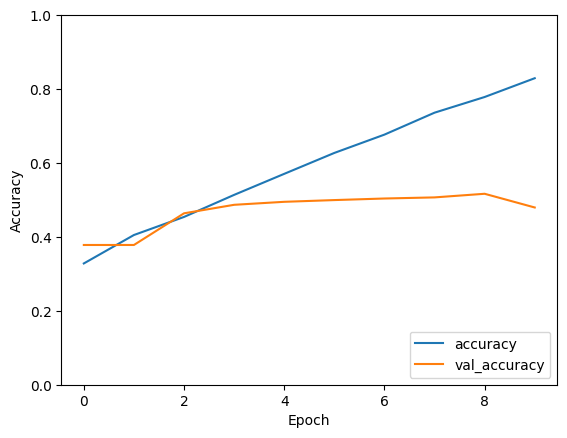

74/74 - 0s - loss: 0.2941 - accuracy: 0.4795 - 352ms/epoch - 5ms/step


In [14]:
model2, history2 = checkmodel(second_model, 10)

Epoch 1/10
294/294 [==============================] - 13s 29ms/step - loss: 0.2639 - accuracy: 0.3142 - val_loss: 0.2324 - val_accuracy: 0.3564
Epoch 2/10
294/294 [==============================] - 7s 24ms/step - loss: 0.2226 - accuracy: 0.3940 - val_loss: 0.2084 - val_accuracy: 0.4049
Epoch 3/10
294/294 [==============================] - 7s 25ms/step - loss: 0.1986 - accuracy: 0.4718 - val_loss: 0.1940 - val_accuracy: 0.5094
Epoch 4/10
294/294 [==============================] - 7s 24ms/step - loss: 0.1846 - accuracy: 0.5159 - val_loss: 0.1754 - val_accuracy: 0.5610
Epoch 5/10
294/294 [==============================] - 7s 24ms/step - loss: 0.1704 - accuracy: 0.5610 - val_loss: 0.1708 - val_accuracy: 0.5665
Epoch 6/10
294/294 [==============================] - 7s 24ms/step - loss: 0.1587 - accuracy: 0.5941 - val_loss: 0.1719 - val_accuracy: 0.5656
Epoch 7/10
294/294 [==============================] - 7s 25ms/step - loss: 0.1479 - accuracy: 0.6306 - val_loss: 0.1566 - val_accuracy: 0.617

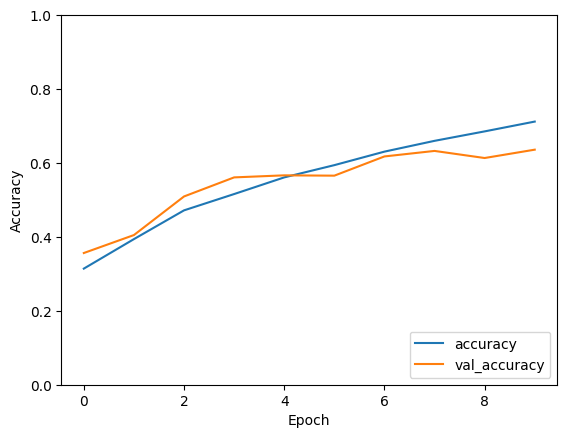

74/74 - 1s - loss: 0.1539 - accuracy: 0.6360 - 527ms/epoch - 7ms/step


In [15]:
#Third model
third_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    # Conv2D(128, (3, 3), activation="relu"),
    # Conv2D(128, (3, 3), activation="relu"),
    # MaxPooling2D((2, 2), strides=(3, 3)),

    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])
model3, history3 = checkmodel(third_model, 10)

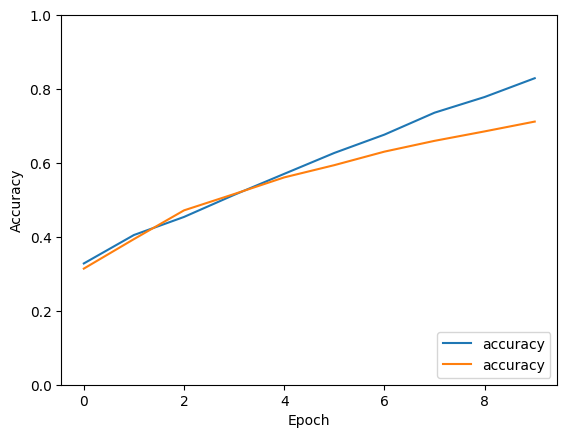

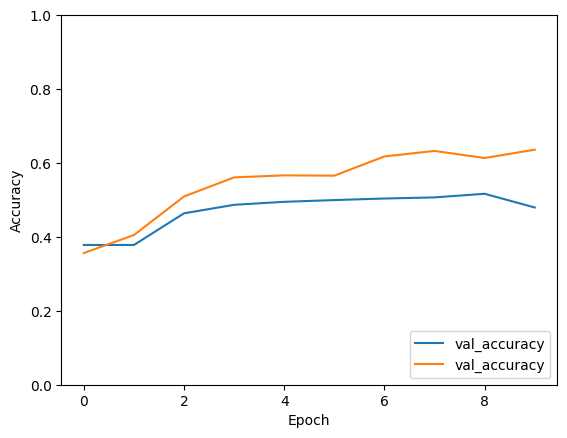

74/74 - 0s - loss: 0.2941 - accuracy: 0.4795 - 314ms/epoch - 4ms/step
74/74 - 0s - loss: 0.1539 - accuracy: 0.6360 - 410ms/epoch - 6ms/step


In [16]:
comparegraph(history2, history3)
compareacc(model2, model3)

Epoch 1/30
294/294 [==============================] - 9s 21ms/step - loss: 0.4058 - accuracy: 0.1839 - val_loss: 0.2583 - val_accuracy: 0.3001
Epoch 2/30
294/294 [==============================] - 6s 20ms/step - loss: 0.3057 - accuracy: 0.2829 - val_loss: 0.2557 - val_accuracy: 0.3001
Epoch 3/30
294/294 [==============================] - 6s 20ms/step - loss: 0.2926 - accuracy: 0.2992 - val_loss: 0.2577 - val_accuracy: 0.3001
Epoch 4/30
294/294 [==============================] - 6s 21ms/step - loss: 0.2869 - accuracy: 0.3032 - val_loss: 0.2547 - val_accuracy: 0.3001
Epoch 5/30
294/294 [==============================] - 6s 21ms/step - loss: 0.2809 - accuracy: 0.3041 - val_loss: 0.2544 - val_accuracy: 0.3001
Epoch 6/30
294/294 [==============================] - 6s 21ms/step - loss: 0.2798 - accuracy: 0.3041 - val_loss: 0.2559 - val_accuracy: 0.3001
Epoch 7/30
294/294 [==============================] - 6s 21ms/step - loss: 0.2746 - accuracy: 0.3041 - val_loss: 0.2535 - val_accuracy: 0.3001

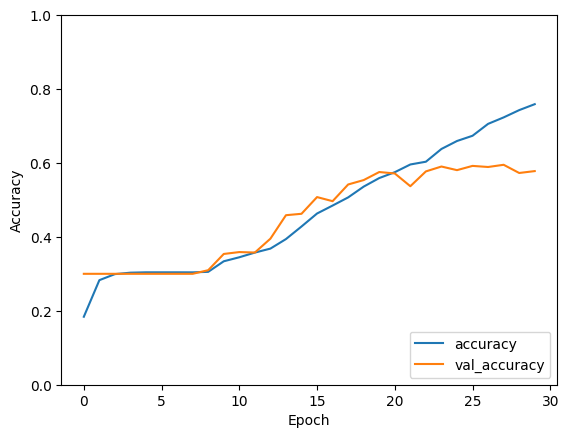

74/74 - 0s - loss: 0.2052 - accuracy: 0.5780 - 489ms/epoch - 7ms/step


In [29]:
# Model Creation
timModel = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((3, 3)),

    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((3, 3)),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.6),
    Dense(12)
])
model4, history4 = checkmodel(timModel, 30)

In [38]:
prediction = model4.predict(xtest)
testSize = int(input("input test size: "))
count = 0
for i in range(testSize):
  pred = decode(prediction[i])
  real = decode(ytest[i])
  plotImage(xtest[i], "%s (pred) - %s (real)" % (pred, real))
  if pred == real:
    count = count + 1
print("acc = %f" % (count/testSize))

Output hidden; open in https://colab.research.google.com to view.

In [28]:
len(xtest)

2346

In [ ]:
# Commit changes
copytogit()
commitandpush(input("Insert Commit Comment: "))